## Import Packages

In [2]:
import pandas as pd
import numpy as np

## Generate Data

We decided to merge the datasets ourselves to better practice preprocessing.

In [3]:
# Names of the airlines
names = pd.read_csv("data/raw_data/CARRIER_DECODE.csv")
names.drop_duplicates(inplace=True)
names.drop_duplicates(subset=['OP_UNIQUE_CARRIER'], inplace=True)

In [4]:
# Passenger handlings
employees = pd.read_csv('data/raw_data/P10_EMPLOYEES.csv')
employees = employees[['OP_UNIQUE_CARRIER', 'PASS_GEN_SVC_ADMIN', 'PASSENGER_HANDLING']]
employees = employees.groupby('OP_UNIQUE_CARRIER').sum().reset_index()

In [5]:
# Cities Data
cities = pd.read_csv('data/raw_data/airports_list.csv')

In [6]:
# Weather Data
weather = pd.read_csv('data/raw_data/airport_weather_2019.csv')

# In the DATE column, only show rows which have the format YYYY-MM-DD using regex
slash_indices = weather[weather['DATE'].str.contains(r'\d+/\d+/\d{4}')].index

weather['DATE'].loc[slash_indices] =  weather.loc[slash_indices]['DATE'].apply(lambda x: x.split('/')[2] + '-' + x.split('/')[0] + '-' + x.split('/')[1] if len(x.split('/')) > 1 else x)

weather_merge = pd.merge(cities, weather, how='left', on='NAME')
weather_merge.drop(weather_merge.loc[weather_merge['ORIGIN_AIRPORT_ID'].isna()].index, axis=0, inplace=True)

weather_merge['MONTH'] = pd.DatetimeIndex(weather_merge['DATE']).month
weather_merge['DAY_OF_MONTH'] = pd.DatetimeIndex(weather_merge['DATE']).day

C:\Users\jcmuf\AppData\Local\Temp\ipykernel_31144\1207164921.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  weather['DATE'].loc[slash_indices] =  weather.loc[slash_indices]['DATE'].apply(lambda x: x.split('/')[2] + '-' + x.split('/')[0] + '-' + x.split('/')[1] if len(x.split('/')) > 1 else x)


In [7]:
# Aircraft Inventory 
aircraft = pd.read_csv("data/raw_data/B43_AIRCRAFT_INVENTORY.csv",encoding='latin1')

In [8]:
def month_cleanup(monthly_data, aircraft, names, weather):
    # Dont include aircraft data, monthly airport passengers, 

    # MERGING
    # Merge to get proper carrier name
    print("Applying Carrier Names - CARRIER_NAME")  
    monthly_data = pd.merge(monthly_data, names, how='left', on=['OP_UNIQUE_CARRIER'])
    print(len(monthly_data))
    
    # FEATURE ENGINEERING - PLANE AGE
    # Calculate age of plane
    print("Calculate Fleet Age - PLANE_AGE")
    monthly_data = pd.merge(monthly_data, aircraft, how="left", on='TAIL_NUM')
    monthly_data['MANUFACTURE_YEAR'].fillna((monthly_data['MANUFACTURE_YEAR'].mean()), inplace=True)
    monthly_data['PLANE_AGE'] = 2020 - monthly_data['MANUFACTURE_YEAR']
    print(len(monthly_data))

    # FEATURE ENGINEERING - PREVIOUS AIRPORT
    # Get previous airport for tail number
    #print("Adding airports - PREVIOUS_AIRPORT")
    #segment_temp = monthly_data[['DAY_OF_MONTH', 'TAIL_NUM', 'DISPLAY_AIRPORT_NAME', 'SEGMENT_NUMBER']]
    #monthly_data = pd.merge_asof(monthly_data.sort_values('SEGMENT_NUMBER'), segment_temp.sort_values('SEGMENT_NUMBER'), on='SEGMENT_NUMBER', by=['DAY_OF_MONTH', 'TAIL_NUM'], allow_exact_matches=False)
    #monthly_data['DISPLAY_AIRPORT_NAME_y'].fillna('NONE', inplace=True)
    #monthly_data.rename(columns={"DISPLAY_AIRPORT_NAME_y": "PREVIOUS_AIRPORT", "DISPLAY_AIRPORT_NAME_x": "DEPARTING_AIRPORT"}, inplace=True)  

    # MERGING
    # Merge weather data
    print("Adding daily weather data - PRCP, SNOW, SNWD, SMAX, TMIN, AWND")
    monthly_data = pd.merge(monthly_data, weather, how='inner', on=['ORIGIN_AIRPORT_ID', 'MONTH', 'DAY_OF_MONTH'])
    print(len(monthly_data))
    
    # reset index
    monthly_data.reset_index(inplace=True, drop=True)
    
    # print elapsed time
    #print(f'Elapsed Time: {time.time() - start}')
    
    print("FINISHED")
    
    # return cleaned file
    return monthly_data

In [9]:
# Select files with ONTIME_REPORTING in their name

for i in range(12):
    df = pd.read_csv('data/raw_data/ONTIME_REPORTING_{:02d}.csv'.format(i+1))
    dfs = month_cleanup(df, aircraft, names, weather_merge)
    # concat the dataframes every iteration
    if i == 0:
        df_final = dfs
    else:
        df_final = pd.concat([df_final, dfs], axis=0)

Applying Carrier Names - CARRIER_NAME
583985
Calculate Fleet Age - PLANE_AGE
585967
Adding daily weather data - PRCP, SNOW, SNWD, SMAX, TMIN, AWND
529867
FINISHED
Applying Carrier Names - CARRIER_NAME
533175
Calculate Fleet Age - PLANE_AGE
535114
Adding daily weather data - PRCP, SNOW, SNWD, SMAX, TMIN, AWND
483331
FINISHED
Applying Carrier Names - CARRIER_NAME
632074
Calculate Fleet Age - PLANE_AGE
634249
Adding daily weather data - PRCP, SNOW, SNWD, SMAX, TMIN, AWND
572502
FINISHED
Applying Carrier Names - CARRIER_NAME
612023
Calculate Fleet Age - PLANE_AGE
613640
Adding daily weather data - PRCP, SNOW, SNWD, SMAX, TMIN, AWND
555593
FINISHED
Applying Carrier Names - CARRIER_NAME
636390
Calculate Fleet Age - PLANE_AGE
637068
Adding daily weather data - PRCP, SNOW, SNWD, SMAX, TMIN, AWND
575980
FINISHED
Applying Carrier Names - CARRIER_NAME
636691
Calculate Fleet Age - PLANE_AGE
637418
Adding daily weather data - PRCP, SNOW, SNWD, SMAX, TMIN, AWND
572987
FINISHED
Applying Carrier Names

## Exploratory Data Analysis

In [17]:
df_final.shape

(6708260, 72)

In [18]:
df_final.columns

Index(['MONTH', 'DAY_OF_MONTH', 'DAY_OF_WEEK', 'OP_UNIQUE_CARRIER', 'TAIL_NUM',
       'OP_CARRIER_FL_NUM', 'ORIGIN_AIRPORT_ID', 'ORIGIN',
       'ORIGIN_CITY_NAME_x', 'DEST_AIRPORT_ID', 'DEST', 'DEST_CITY_NAME',
       'CRS_DEP_TIME', 'DEP_TIME', 'DEP_DELAY_NEW', 'DEP_DEL15',
       'DEP_TIME_BLK', 'CRS_ARR_TIME', 'ARR_TIME', 'ARR_DELAY_NEW',
       'ARR_TIME_BLK', 'CANCELLED', 'CANCELLATION_CODE', 'CRS_ELAPSED_TIME',
       'ACTUAL_ELAPSED_TIME', 'DISTANCE', 'DISTANCE_GROUP', 'CARRIER_DELAY',
       'WEATHER_DELAY', 'NAS_DELAY', 'SECURITY_DELAY', 'LATE_AIRCRAFT_DELAY',
       'Unnamed: 32', 'AIRLINE_ID', 'CARRIER_NAME', 'MANUFACTURE_YEAR',
       'NUMBER_OF_SEATS', 'PLANE_AGE', 'DISPLAY_AIRPORT_NAME',
       'ORIGIN_CITY_NAME_y', 'NAME', 'STATION', 'DATE', 'AWND', 'PGTM', 'PRCP',
       'SNOW', 'SNWD', 'TAVG', 'TMAX', 'TMIN', 'WDF2', 'WDF5', 'WSF2', 'WSF5',
       'WT01', 'WT02', 'WT03', 'WT04', 'WT05', 'WT06', 'WT07', 'WT08', 'WT09',
       'WESD', 'WT10', 'PSUN', 'TSUN', 'SN32', 'S

In [29]:
import seaborn as sns
import matplotlib.pyplot as plt

In [26]:
delay_reasons = df_final[['CARRIER_DELAY','WEATHER_DELAY', 'NAS_DELAY', 'SECURITY_DELAY']]
delay_reasons


,CARRIER_DELAY,WEATHER_DELAY,NAS_DELAY,SECURITY_DELAY
0,NaN,NaN,NaN,NaN
1,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN
...,...,...,...,...
564267,NaN,NaN,NaN,NaN
564268,NaN,NaN,NaN,NaN
564269,0.0,0.0,19.0,0.0
564270,NaN,NaN,NaN,NaN


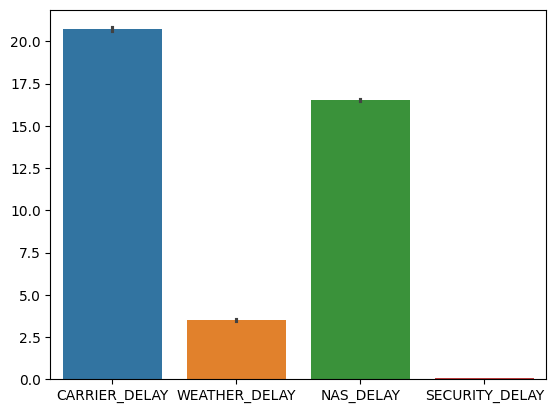

In [33]:
sns.barplot(delay_reasons)
plt.show()

There are barely any records in these columns. We should remove them.

In [34]:
weather_codes = df_final[['AWND', 'PGTM', 'PRCP',
       'SNOW', 'SNWD', 'TAVG', 'TMAX', 'TMIN', 'WDF2', 'WDF5', 'WSF2', 'WSF5',
       'WT01', 'WT02', 'WT03', 'WT04', 'WT05', 'WT06', 'WT07', 'WT08', 'WT09',
       'WESD', 'WT10', 'PSUN', 'TSUN', 'SN32', 'SX32', 'TOBS', 'WT11']]

weather_codes

,AWND,PGTM,PRCP,SNOW,SNWD,TAVG,TMAX,TMIN,WDF2,WDF5,...,WT08,WT09,WESD,WT10,PSUN,TSUN,SN32,SX32,TOBS,WT11
0,6.49,NaN,0.00,0.0,0.0,53.0,69.0,43.0,320.0,320.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,6.49,NaN,0.00,0.0,0.0,53.0,69.0,43.0,320.0,320.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,6.49,NaN,0.00,0.0,0.0,53.0,69.0,43.0,320.0,320.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,6.49,NaN,0.00,0.0,0.0,53.0,69.0,43.0,320.0,320.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,6.49,NaN,0.00,0.0,0.0,53.0,69.0,43.0,320.0,320.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
564267,7.83,2149.0,0.02,0.3,7.1,15.0,29.0,11.0,310.0,330.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
564268,7.83,2149.0,0.02,0.3,7.1,15.0,29.0,11.0,310.0,330.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
564269,7.83,2149.0,0.02,0.3,7.1,15.0,29.0,11.0,310.0,330.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
564270,7.83,2149.0,0.02,0.3,7.1,15.0,29.0,11.0,310.0,330.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## Preprocessing

In [3]:
print("Let's preprocess")
print("NO")

Let's preprocess


## Training

## Evaluation